In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from sklearn.model_selection import train_test_split
from beam_utils import calc_beam_pattern,pow_2_dB,dB_2_pow
import torch
from DL_utils import Joint_BF_Autoencoder,eval_model
import DeepMIMO
from os.path import exists

In [19]:
scenario = 'Boston5G_28'
activated_BS = 1
random_UE_rotation = False
array_type = 'ULA'

tx_power_dBm = 40
noise_PSD_dB = -143
BW = 50e6
noise_power_dBm = noise_PSD_dB + 10*np.log10(BW) # dBm
measurement_gain = 16.0
measurement_gain_dB = 10*np.log10(measurement_gain)
IA_threshold = -5
measurement_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain
h_NMSE_dB = -np.inf
dataset_split_seed = 7

In [14]:
scenario == 'Boston5G_28'
ue_row_first = 1
ue_row_last = 1622

parameters = DeepMIMO.default_params()
parameters['dataset_folder'] = 'D:/Github Repositories/DeepMIMO-codes/DeepMIMOv2/Raytracing_scenarios'

parameters['scenario'] = scenario
parameters['num_paths'] = 15
parameters['active_BS'] = [activated_BS]
parameters['user_row_first'] = ue_row_first
parameters['user_row_last'] = ue_row_last
parameters['row_subsampling'] = 1
parameters['user_subsampling'] = 1

parameters['bs_antenna']['shape'] = np.array([1, 64, 1])
parameters['bs_antenna']['spacing'] = 0.5
parameters['bs_antenna']['radiation_pattern'] = 'isotropic'

parameters['ue_antenna']['shape'] = np.array([1, 32, 1])
parameters['ue_antenna']['spacing'] = 0.5
if random_UE_rotation:
    parameters['ue_antenna']['rotation'] = np.array([[-180,180],[0,0],[0,0]])
parameters['ue_antenna']['radiation_pattern'] = 'isotropic'

parameters['enable_BS2BS'] = 0

parameters['OFDM_channels'] = 1 # Frequency (OFDM) or time domain channels
parameters['OFDM']['subcarriers'] = 512
parameters['OFDM']['subcarriers_limit'] = 1
parameters['OFDM']['subcarriers_sampling'] = 1
parameters['OFDM']['bandwidth'] = BW/1e9
parameters['OFDM']['RX_filter'] = 0

dataset = DeepMIMO.generate_data(parameters)


Basestation 1

UE-BS Channels


Generating channels: 100%|██████████| 965090/965090 [00:30<00:00, 31973.97it/s]  


In [15]:
h = dataset[0]['user']['channel'].squeeze(axis=-1)
valid_ue_idc = np.array([ue_i for (ue_i,ue_h) in enumerate(h) if not (ue_h==0).all()])
print('Keep {} out of {} UEs that have valid paths.'.format(len(valid_ue_idc),h.shape[0]))
h = h[valid_ue_idc]
if IA_threshold > -np.inf:
    eigen_bf_gain = np.linalg.eigvalsh(np.transpose(h.conj(),axes=(0,2,1)) @ h)[:,-1]
    eigen_snr = tx_power_dBm+10*np.log10(eigen_bf_gain)-noise_power_dBm
    reachable_ue = eigen_snr>IA_threshold   
    print('Removed {} out of {} UEs that are below the IA SNR threshold ({} dB).'.format((~reachable_ue).sum(),h.shape[0],IA_threshold))    
    h = h[reachable_ue]

norm_factor = np.max(abs(h))
h_scaled = (h.T/norm_factor).T

Keep 105842 out of 965090 UEs that have valid paths.
Removed 34616 out of 105842 UEs that are below the IA SNR threshold (-5 dB).


In [16]:
# Training and testing data:
# --------------------------
train_idc, test_idc = train_test_split(np.arange(h_scaled.shape[0]),test_size=0.4,random_state=7)
val_idc, test_idc = train_test_split(test_idc,test_size=0.5,random_state=7)
num_antenna_Tx = np.prod(parameters['bs_antenna'][0]['shape'])
num_antenna_Rx = np.prod(parameters['ue_antenna']['shape'])

x_test = h_scaled[test_idc]
torch_x_test = torch.from_numpy(x_test)

h_test = h[test_idc]

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


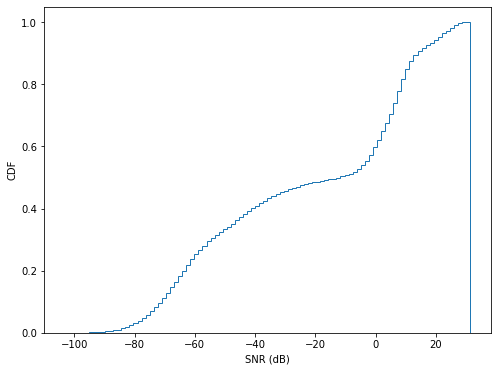

Misdetection probability: 46.60%


In [20]:
n_probing_beam = 64
feedback_mode = 'diagonal'
num_feedback = None
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'
loss_fn_name = 'BF_IA_loss'
gamma = 1.0

model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                noise_power=measurement_noise_power, norm_factor=norm_factor,
                                feedback=feedback_mode,num_feedback = num_feedback,
                                learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
model_savefname_prefix = './Saved_Models/'
model_setup_params = ("{}_BS_{}_"+
                   "{}x{}_{}_"+
                   "UE_rot_{}_"+
                   "{}_{}_probe_"+
                   "{}_FB_{}_"+
                   "{}_gamma_{}_"+
                   "train_noise_{}_dBm_"+
                   "meas_gain_{}_"+
                   "IA_thresh_{}_"+
                   "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],
                                             num_antenna_Tx, num_antenna_Rx, array_type,
                                             random_UE_rotation,
                                             n_probing_beam, learned_probing,                                        
                                             feedback_mode, num_feedback,
                                             loss_fn_name, gamma,
                                             noise_power_dBm,
                                             measurement_gain,
                                             IA_threshold,
                                             h_NMSE_dB)
state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
model.load_state_dict(state_dict_load)
model.eval()

with torch.no_grad():
    tx_beam_pred, rx_beam_pred, probing_bf_power = model(torch_x_test)
    rx_beam_pred = rx_beam_pred.detach().unsqueeze(dim=-1).numpy() # n_batch x num_antenna_Rx x 1
    tx_beam_pred = tx_beam_pred.detach().unsqueeze(dim=-1).numpy() # n_batch x num_antenna_Tx x 1
    predicted_bf_gain = np.transpose(rx_beam_pred.conj(),axes=(0,2,1)) @ h_test @ tx_beam_pred
    predicted_bf_gain = np.power(np.absolute(predicted_bf_gain),2).squeeze()   

    probing_codebook_Tx,probing_codebook_Rx = model.get_probing_codebooks()
    probing_codebook_bf_gain = np.power(np.absolute(probing_codebook_Rx.conj().T @ h_test @ probing_codebook_Tx),2)
    if feedback_mode == 'diagonal':
        probing_codebook_bf_gain = np.diagonal(probing_codebook_bf_gain,axis1=1,axis2=2) # n_batch x num_beam_Tx
    elif feedback_mode == 'max':
        probing_codebook_bf_gain = probing_codebook_bf_gain.max(axis=1) # n_batch x num_beam_Tx
    else:
        probing_codebook_bf_gain = probing_codebook_bf_gain.reshape(probing_codebook_bf_gain.shape[0],-1) # n_batch x (num_beam_Tx * num_beam_Rx)
    probing_codebook_bf_gain = probing_codebook_bf_gain.max(axis=-1)

model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm

probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
misdetection_rate = (probing_beam_max_snr<IA_threshold).mean()

plt.figure(figsize=(8,6))
plt.hist(model_snr,bins=100,density=True,cumulative=True,histtype='step',label='DLGF')
plt.xlabel('SNR (dB)')
plt.ylabel('CDF')
plt.show()

print('Misdetection probability: {:.2f}%'.format(misdetection_rate*100))

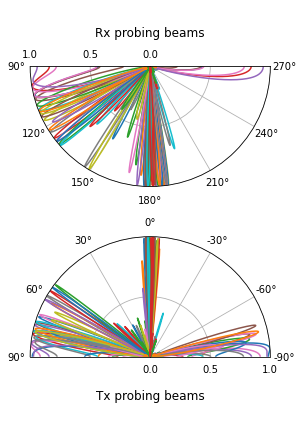

In [21]:
probing_codebook_Tx,probing_codebook_Rx = model.get_probing_codebooks()

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(211,polar=True)
for beam_i, beam in enumerate(probing_codebook_Rx.T):
    phi, bf_gain = calc_beam_pattern(beam,phi_min=np.pi/2,phi_max=3*np.pi/2,n_antenna=num_antenna_Rx)
    ax.plot(phi,bf_gain)
ax.grid(True)
ax.set_rmax(1)
ax.set_rticks([0,0.5, 1])
ax.set_rlabel_position(270) 
ax.set_thetamin(90)
ax.set_thetamax(270)
ax.set_theta_zero_location("N")
ax.set_title('Rx probing beams',y=0.85)

ax = fig.add_subplot(212,polar=True)
for beam_i, beam in enumerate(probing_codebook_Tx.T):
    phi, bf_gain = calc_beam_pattern(beam,phi_min=-np.pi/2,phi_max=np.pi/2,n_antenna=num_antenna_Tx)
    ax.plot(phi,bf_gain)
ax.grid(True)
ax.set_rmax(1)
ax.set_rticks([0,0.5, 1])
ax.set_rlabel_position(-90)  
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_theta_zero_location("N")
ax.set_title('Tx probing beams',y=0.05)

fig.tight_layout(h_pad=-7)